In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from timeit import default_timer as timer
from tqdm.auto import tqdm
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
import torchmetrics
import requests
from pathlib import Path

if Path('helper_functions.py').is_file():
    print('helper_functions.py already exists, skipping download')
else:
    print('Downloading helper_functions.py')
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
    with open('helper_functions.py', 'wb') as f:
        f.write(request.content)
        
from helper_functions import accuracy_fn

helper_functions.py already exists, skipping download


In [2]:
# set up data
torch.manual_seed(42)
train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

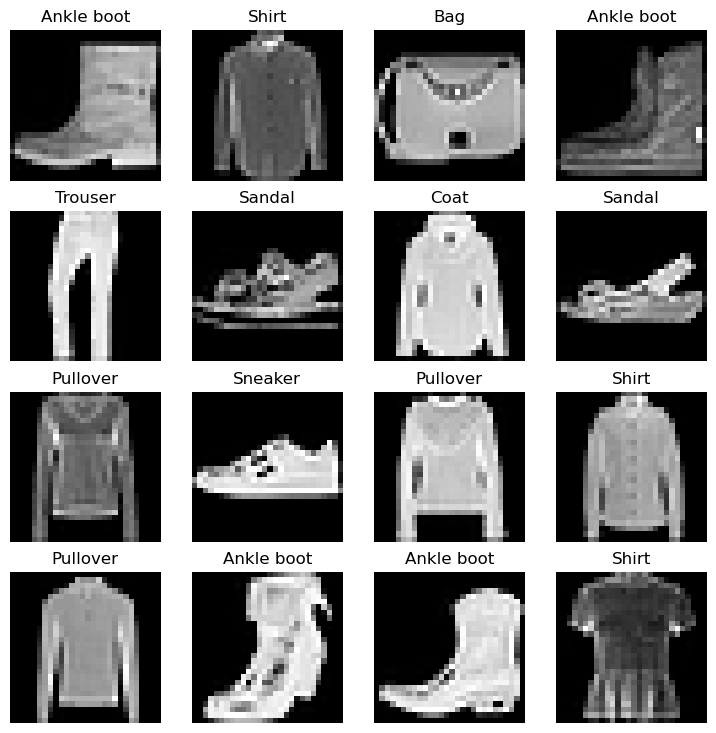

In [3]:
# visualize
class_names = train_data.classes
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(class_names[label])
    plt.axis(False)

In [4]:
# create batches (dataloaders)
BATCH_SIZE = 32

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

train_features_batch, train_labels_batch = next(iter(train_dataloader))

In [5]:
# build a baseline model

# create a flatten layer
flatten_model = nn.Flatten()

# what does it do?
test = train_features_batch[0] # torch.Size([1, 28, 28])
output = flatten_model(test)   # torch.Size([1, 784])

# we flatten data since linear layers cannot handle multi dimensonal data

In [6]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, hidden_units),   # does the model need non-linearity?
            nn.Linear(hidden_units, output_shape)
        )
    
    def forward(self, x):
        return self.layer_stack(x)

In [7]:
# instantiate the model
torch.manual_seed(42)
model_0 = FashionMNISTModelV0(784, 16, len(class_names))

# loss function, optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

# timer function
def print_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

train_time_start = timer()

# training loop
# training steps and loss calculations will be made on each batch, not each epoch
epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-----")
    
    train_loss = 0
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()
        y_pred = model_0(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        # optimizer updates params once per batch!
        optimizer.step()
    
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples...")
            
    train_loss /= len(train_dataloader)
    
    model_0.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for X, y in test_dataloader:
            test_pred = model_0(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
    
    print(f'\nTrain Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}\n')

train_time_end = timer()
total_train_time_model_0 = \
print_train_time(train_time_start, train_time_end, device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-----
Looked at 0/60000 samples...
Looked at 12800/60000 samples...
Looked at 25600/60000 samples...
Looked at 38400/60000 samples...
Looked at 51200/60000 samples...

Train Loss: 0.5855 | Test Loss: 0.5258 | Test Acc: 81.0503

Epoch: 1
-----
Looked at 0/60000 samples...
Looked at 12800/60000 samples...
Looked at 25600/60000 samples...
Looked at 38400/60000 samples...
Looked at 51200/60000 samples...

Train Loss: 0.4758 | Test Loss: 0.4820 | Test Acc: 82.7077

Epoch: 2
-----
Looked at 0/60000 samples...
Looked at 12800/60000 samples...
Looked at 25600/60000 samples...
Looked at 38400/60000 samples...
Looked at 51200/60000 samples...

Train Loss: 0.4549 | Test Loss: 0.4915 | Test Acc: 82.4780

Train time on cpu: 28.488 seconds


In [8]:
# evaluate the model
def eval_model(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    accuracy_fn):

    '''
    Returns a dictionary containing the results of model predicting on data_loader
    '''
    
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y, y_pred.argmax(dim=1))
        
        loss /= len(data_loader)
        acc /= len(data_loader)
    
    return {'model_name': model.__class__.__name__,
            'model_loss': loss.item(),
            'model_acc': acc}

model_0_results = eval_model(model_0, test_dataloader, loss_fn, accuracy_fn)
model_0_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.4914553165435791,
 'model_acc': 82.47803514376997}

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# create a model with non-linearity
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape:int):
        torch.manual_seed(42)
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_shape),
            nn.ReLU()
        )
    def forward(self, x):
        return self.layer_stack(x)

model_1 = FashionMNISTModelV1(784, 10, len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

# functionalize training and testing loop
def train_step(model, data_loader, loss_fn, optimizer, accuracy_fn, device=device):
    torch.manual_seed(42)
    train_loss, train_acc = 0, 0
    model.train()
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y, y_pred.argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    
    print(f'Train Loss: {train_loss:.5f} | Train Acc: {train_acc:.2f}')
    
def test_step(model, data_loader, loss_fn, accuracy_fn, device=device):
    torch.manual_seed(42)
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y, test_pred.argmax(dim=1))
        
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        
    print(f'Test Loss: {test_loss:5f} | Test Acc: {test_acc:.2f}\n')

epochs = 3
start_time = timer()

for epoch in tqdm(range(epochs)):
    
    print(f'Epoch: {epoch}\n-----')

    train_step(model_1, train_dataloader, loss_fn, optimizer, accuracy_fn)
    test_step(model_1, test_dataloader, loss_fn, accuracy_fn)

end_time = timer()

model_1_train_time = print_train_time(start_time, end_time, device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-----
Train Loss: 1.09199 | Train Acc: 61.34
Test Loss: 0.956365 | Test Acc: 65.00

Epoch: 1
-----
Train Loss: 0.80838 | Train Acc: 70.84
Test Loss: 0.715623 | Test Acc: 74.49

Epoch: 2
-----
Train Loss: 0.66979 | Train Acc: 75.97
Test Loss: 0.706713 | Test Acc: 74.78

Train time on cpu: 28.839 seconds


## Convolutional Neural Network

In [10]:
class FashionMNISTModelV2(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        torch.manual_seed(42)
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape, 
                out_channels=hidden_units, 
                kernel_size=3,
                stride=1,
                padding=1
            ), 
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2)            
        )
        
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units*7*7, output_shape)
        )
    
    def forward(self, x):
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))

# first param is 1 because there is only 1 color channel
model_2 = FashionMNISTModelV2(1, 10, len(class_names))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

epochs = 21
start = timer()

for epoch in tqdm(range(epochs)) :
    print(f"Epoch: {epoch}\n------")
    train_step(model_2, train_dataloader, loss_fn, optimizer, accuracy_fn)
    test_step(model_2, test_dataloader, loss_fn, accuracy_fn)
    
end = timer()

total_time = print_train_time(start, end, device)

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 0
------
Train Loss: 0.59292 | Train Acc: 78.51
Test Loss: 0.388684 | Test Acc: 85.88

Epoch: 1
------
Train Loss: 0.36193 | Train Acc: 86.99
Test Loss: 0.343976 | Test Acc: 87.50

Epoch: 2
------
Train Loss: 0.32571 | Train Acc: 88.24
Test Loss: 0.331254 | Test Acc: 87.79

Epoch: 3
------
Train Loss: 0.30429 | Train Acc: 88.97
Test Loss: 0.323940 | Test Acc: 88.28

Epoch: 4
------
Train Loss: 0.29060 | Train Acc: 89.49
Test Loss: 0.312053 | Test Acc: 88.49

Epoch: 5
------
Train Loss: 0.27852 | Train Acc: 89.91
Test Loss: 0.309045 | Test Acc: 88.82

Epoch: 6
------
Train Loss: 0.27027 | Train Acc: 90.07
Test Loss: 0.300952 | Test Acc: 89.20

Epoch: 7
------
Train Loss: 0.26395 | Train Acc: 90.39
Test Loss: 0.294671 | Test Acc: 89.24

Epoch: 8
------
Train Loss: 0.25833 | Train Acc: 90.61
Test Loss: 0.291881 | Test Acc: 89.35

Epoch: 9
------
Train Loss: 0.25543 | Train Acc: 90.58
Test Loss: 0.295000 | Test Acc: 89.23

Epoch: 10
------
Train Loss: 0.25260 | Train Acc: 90.81
Test

Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

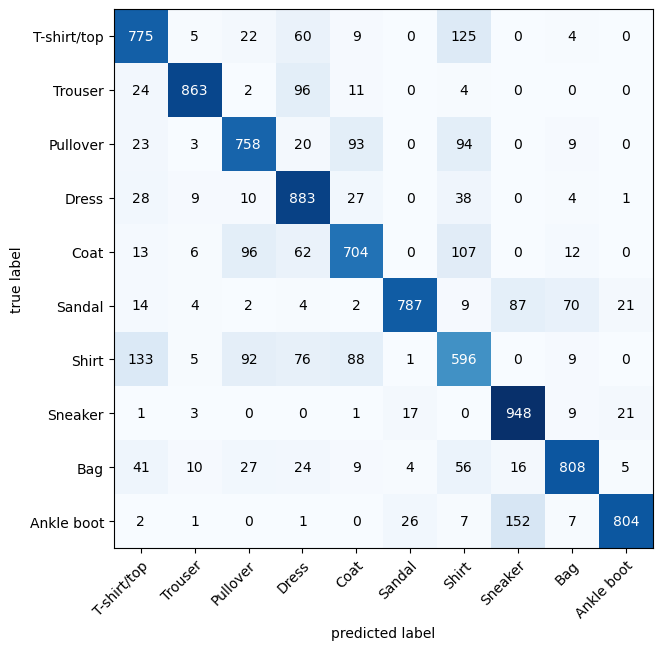

In [11]:
# making predictions
y_preds = []
model_2.eval()

with torch.inference_mode():
    
    for X, y in tqdm(test_dataloader, desc="Making predictions..."):
        X, y = X.to(device), y.to(device)
        y_logits = model_2(X)
        y_label = torch.softmax(y_logits.squeeze(), dim=0).argmax(dim=1)
        y_preds.append(y_label)
        
y_preds = torch.cat(y_preds)

confmat = ConfusionMatrix(task='multiclass', num_classes=len(class_names))
confmat_tensor = confmat(preds=y_preds, target=test_data.targets)

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
)